# Passive microrheology Analysis
This program analyzes the trajectories of a trapped particle inside an optical tweezer to obtain the rheological moduli G' and G'' of the surrounding medium. The calculation is done following the works of Tassieri et al. see the references below: 
* Tassieri, M. Microrheology with Optical Tweezers: Principles and Applications.  (CRC Press, 2016).
* Preece, D. et al. Optical tweezers: wideband microrheology. Journal of optics 13, 044022 (2011).
* Tassieri, M., Evans, R., Warren, R. L., Bailey, N. J. & Cooper, J. M. Microrheology with optical tweezers: data analysis. New Journal of Physics 14, 115032 (2012).
* Tassieri, M. et al. Measuring storage and loss moduli using optical tweezers: Broadband microrheology. Physical Review E 81, 026308 (2010).

This program is published as a part of associated code for the manuscript "*Programmable Viscoelasticity in Protein-RNA Condensates with Disordered Sticker-Spacer Polypeptides*" by Alshareedah and coworkers. 

Program author: Ibraheem Alshareedah. 
Last updated: Feb 16th 2022

### Importing necessary libraries and defining the functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lumicks.pylake as pylake
from lumicks import pylake
import math
from multipletau import autocorrelate
import array
import lmfit
import scipy as sp
import numpy as np
from scipy.interpolate import interp1d
from obspy.signal.detrend import spline
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import normalize

%matplotlib inline

def ia_autocorr(xpos,ypos,bins,time_interval):
    
    n=np.arange(0,bins)
    k=0
    lagtimes=np.zeros(len(n))
    for i in n:
        lagtimes[k]=math.ceil(1.45**i)
        k=k+1
    k=0
    Ax=np.zeros(len(n))
    Ay=np.zeros(len(n))
    variancey = np.var(ypos,dtype=np.float64)
    variancex = np.var(xpos,dtype=np.float64)
    for dt in lagtimes:
        dt=int(dt)
        Ax[k] = np.mean(xpos[1+dt:len(xpos)-1]*xpos[1:len(xpos)-1-dt])/variancex
        Ay[k] = np.mean(ypos[1+dt:len(ypos)-1]*ypos[1:len(ypos)-1-dt])/variancey


        k=k+1
    return lagtimes*time_interval, Ax, Ay

def compute_autocorrelation(xpos,ypos,dt):
    xpos=xpos-np.mean(xpos)
    ypos=ypos-np.mean(ypos)
    corr_datax = autocorrelate(xpos*1e-9, m=32,deltat=dt, normalize=False)
    corr_datay = autocorrelate(ypos*1e-9, m=32,deltat=dt, normalize=False)
    var1x = sum(xpos*xpos*1e-18)
    var1y = sum(ypos*ypos*1e-18)
    tau=corr_datax[:,0]
    Ax=corr_datax[:,1]/var1x
    Ay = corr_datay[:,1]/var1y    
    return tau, Ax,Ay


def get_stiffness(t,x,y,T):
    variancey = np.var(y,dtype=np.float64)
    variancex = np.var(x,dtype=np.float64)
    k = 1.38064852e-23
    Temp = T+273.15 # 293.15 #20 C 
    kappax = 1e18*k*Temp/variancex 
    kappay = 1e18*k*Temp/variancey 

    return kappax,kappay


def PMR(taunew,Atimenew,g0,gdotinf):

        #calculate -Afreq*omega**2
    
    import math

    hpow=math.log10(1/taunew[0] )
    lpow = math.log10(1/taunew[-1])

    omegas=np.logspace(lpow,hpow,100)
    Afft = np.zeros(100,dtype=complex)
    Afreq = np.zeros(100,dtype=complex)

 
    #Atimenew=[1:len(Atimenew)-1]
    #taunew=[1:len(taunew)-1]
    dA=np.diff(Atimenew)
    dt=np.diff(taunew)
   
    gdot=dA/dt


    k=0
    for omega in omegas:
        Afft[k]=1j*omega*g0 +(1-np.exp(-1j*omega*taunew[0]))*(Atimenew[0]-g0)/taunew[0] + gdotinf*np.exp(-1j*omega*taunew[len(taunew)-1])

        dexp = np.diff(np.exp(-1j*omega*taunew))
        Afft[k]=Afft[k]+sum(-dexp*dA/dt)
        Afreq[k]=-Afft[k]/(omega)**2
        k=k+1
                                                                                                            
    return omegas,Afreq

from pylab import *

def myplot(xlabel,ylabel):
    
    rc('axes', linewidth=1.5)
    fontsize = 14

    ax=gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
        tick.linewidth=1.5
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel(ylabel,fontsize=18)
    plt.legend(frameon=False)
    grid()

# Opening the data file
Here, the code is written to handle .h5 files obtained from Lumicks bluelake software that operates the C-trap correlative optical tweezer-confocal microscopy system. the code can be edited to open other files. The needed data is the X-coordinates, Y-coordinates, and time arrays. 

In [4]:
# List the h5 files in the directory
import os

#testdir = r"C:\Users\Ritika\Box\Ritika Gupta Banerjee Lab\Data\NPM1 Surf6N Project\C-trap Training\19Dec RGRGG 5mgml T40 2.5 mgml 25 mM NaCl 25 mM Tris 20 mM DTT 1 um bead"
testdir = r"D:\Anurag_data\Chilkoti's Lab\POEGMA rB2 sample\Sample 4\Heating\15C\3_1"
os.listdir(testdir)
os.chdir(testdir)
os.getcwd()

files = listdir()
scans = []
fraps=[]
for file in files:
    if '.h5' in file  :
        scans.append(file)
index = np.arange(len(scans))
insca = zip(list(index),scans)
list(insca)


[]

In [3]:
# Pick a file to analyze
index_to_analyze =0
fname=scans[index_to_analyze]
fname=fname[0:len(fname)-3]
file1 = pylake.File(fname+'.h5')
#file2 = pylake.File("data/20180611-161216 Kymograph 6.h5")
#print(file1)

beadms = file1['Tracking Match Score']['Bead 1']
beadms1 = beadms.data
beadx = file1['Bead position']['Bead 1 X']
beadxx = beadx.data
t = beadx.timestamps
t= (t-t[0])/1e9
beady = file1['Bead position']['Bead 1 Y']
beadypos=file1['Bead position']['Bead 1 Y'].data
yposkappa=beadypos-beadypos[0]
beadyy = beady.data
plt.plot(beadxx,beadyy)
xpos=beadxx-beadxx[0]
ypos=beadyy-beadyy[0]
plt.xlabel("X ($\mu$m)",fontsize=12)
plt.ylabel("Y ($\mu$m)",fontsize=12)
plt.savefig(fname+'XYpos.png')
np.savetxt(fname+"something.txt", np.transpose(np.array([xpos, ypos])),delimiter='\t')

IndexError: list index out of range

In [ ]:
beadx.timestamps[1:10], xpos[1:10], ypos[1:10], t[1:10], t[1]-t[0]

In [ ]:
file1['Power controls']['Overall power'].data[:10]

In [22]:
200000*12e-6

2.4

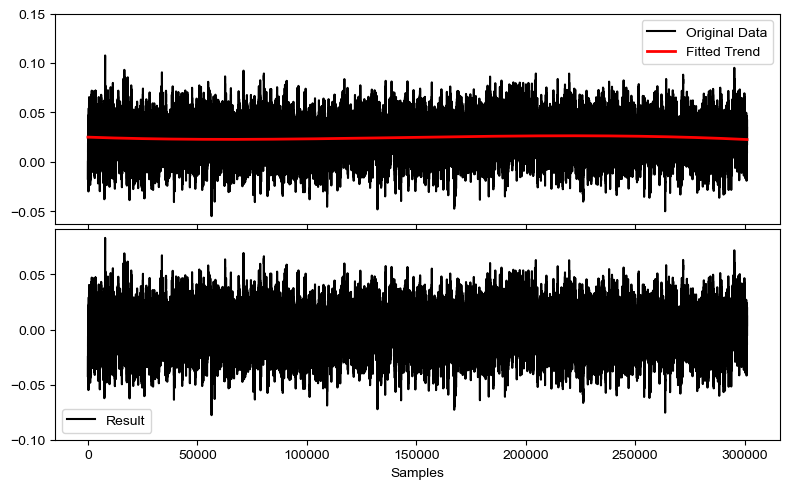

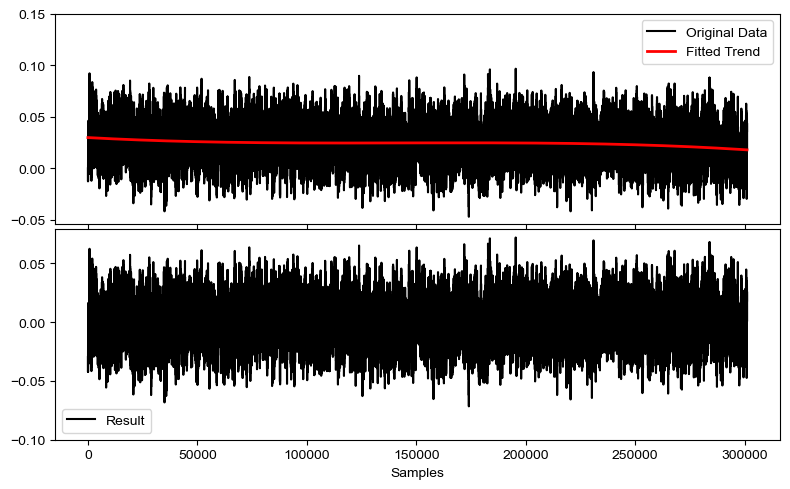

array([-0.02981576, -0.02635701, -0.02383984, ...,  0.02341982,
        0.00056899,  0.01829966])

In [23]:
#correct for drifiting
spline(xpos, order=3, dspline=10000000, plot=True)  
spline(ypos, order=3, dspline=10000000, plot=True) 
#spline(yposkappa, order=2, dspline=20000, plot=True) 


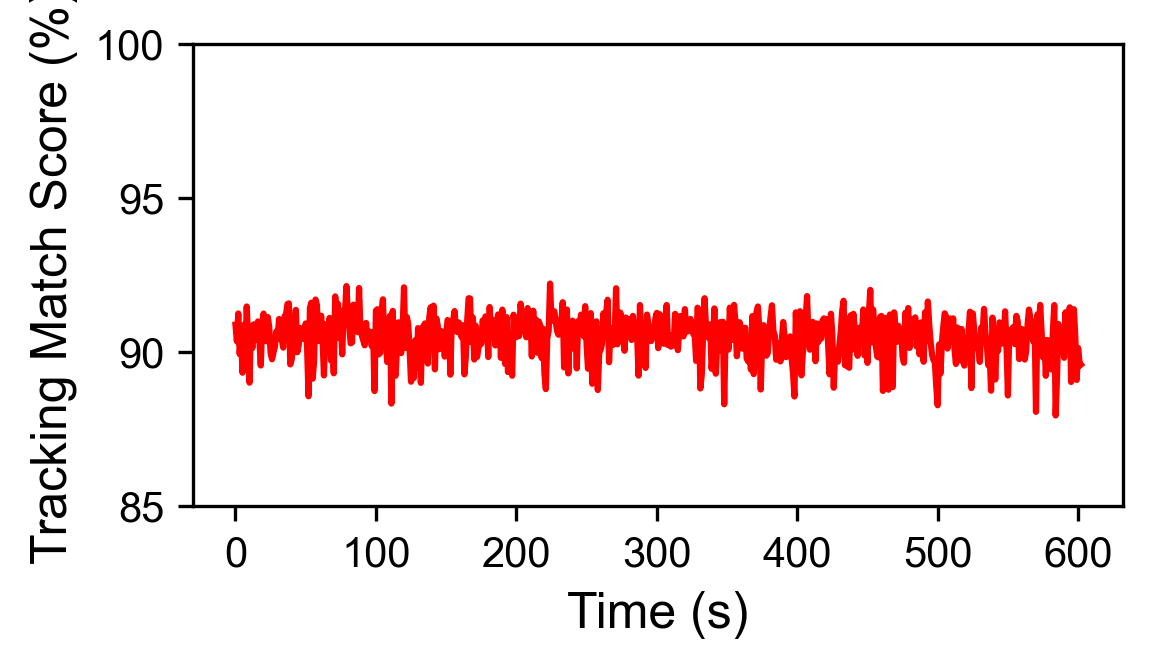

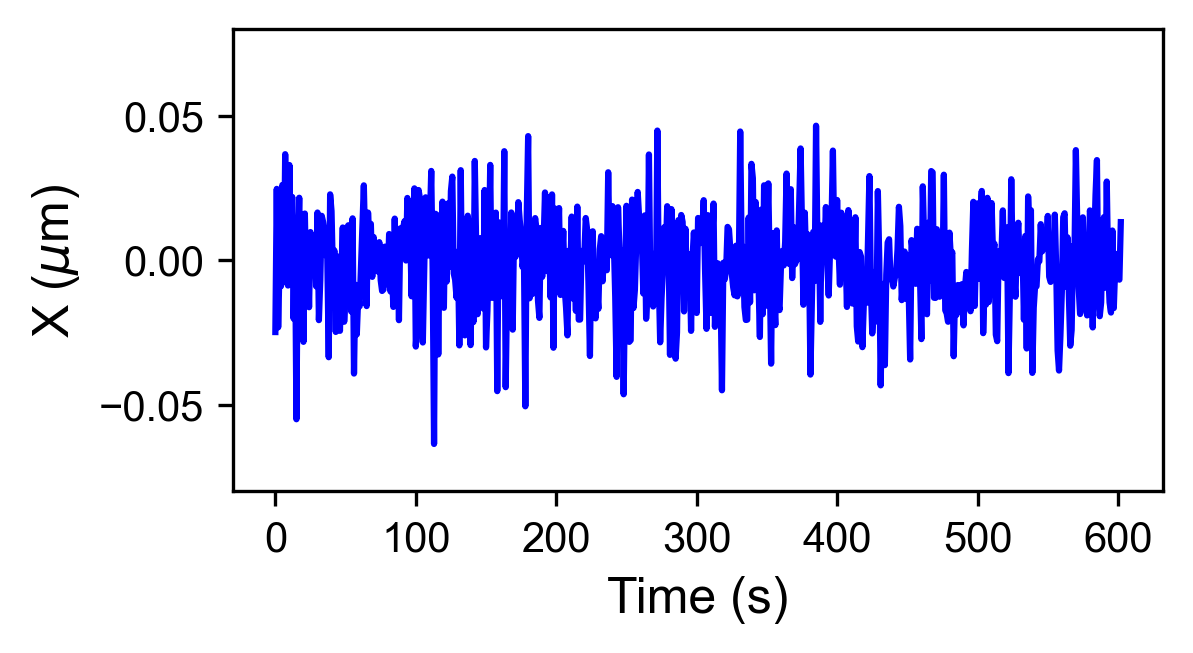

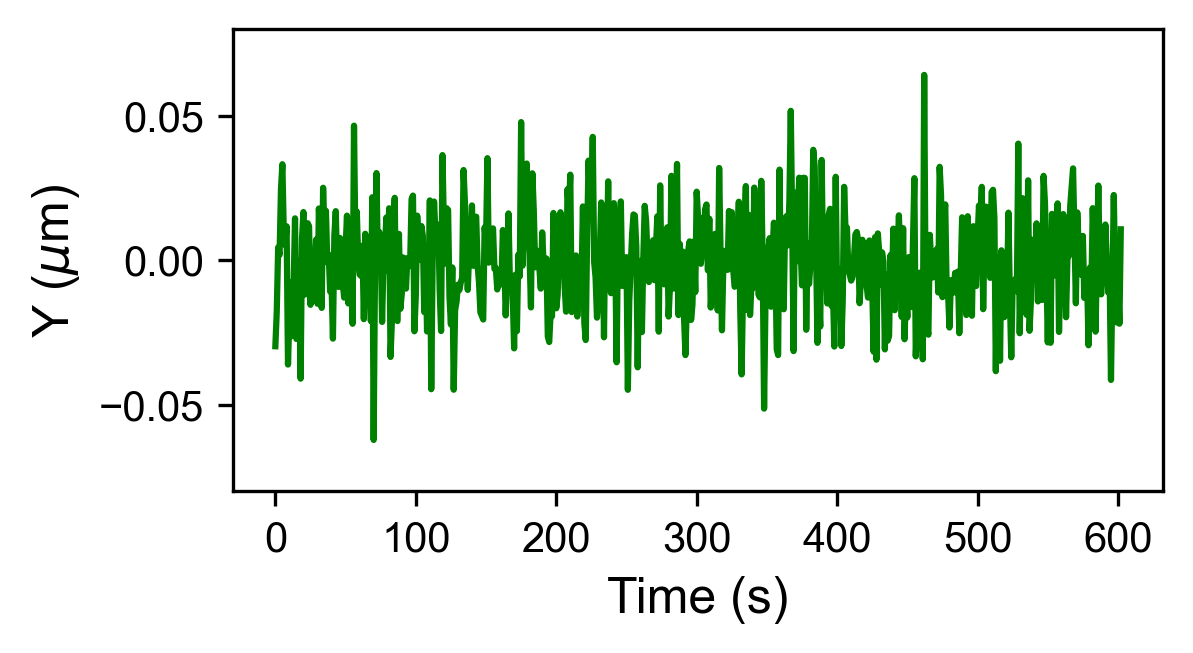

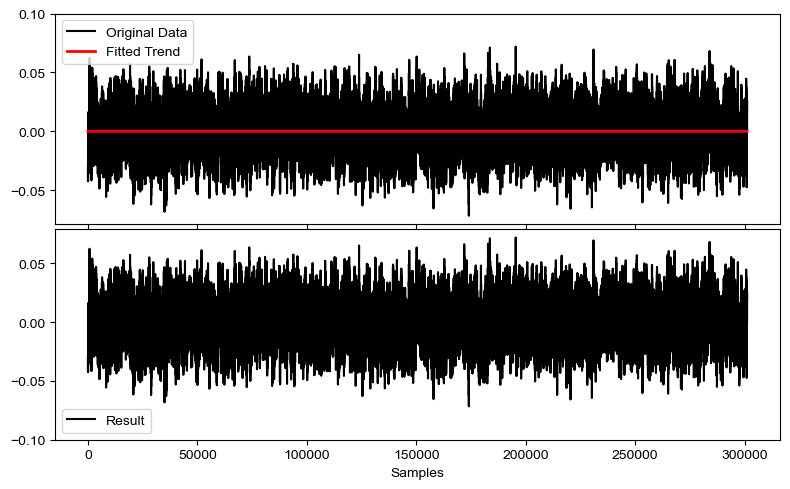

In [24]:
plt.figure(figsize=(4,2),dpi=300)
matplotlib.rcParams['font.sans-serif'] = "Arial"
plt.plot(t[::500],beadms1[::500],'red')
plt.xlabel("Time (s)",fontsize=12)
plt.ylabel("Tracking Match Score (%)",fontsize=12)
plt.ylim([85,100])
plt.savefig(fname+'Tracking match score.svg')
plt.savefig(fname+'Tracking match score.png',bbox_inches='tight')
plt.figure(figsize=(4,2),dpi=300)
matplotlib.rcParams['font.sans-serif'] = "Arial"
plt.plot(t[::500],xpos[::500],'blue')
plt.xlabel("Time (s)",fontsize=12)
plt.ylabel("X ($\mu$m)",fontsize=12)
plt.ylim([-.08,.08])
plt.savefig(fname+'Xpos.svg')
plt.savefig(fname+'Xpos.png',bbox_inches='tight')
np.savetxt(fname+"xpos.txt", np.transpose(np.array([t[::500],xpos[::500]])),delimiter='\t')
plt.figure(figsize=(4,2),dpi=300)
matplotlib.rcParams['font.sans-serif'] = "Arial"
plt.plot(t[::500],ypos[::500],'green')
plt.xlabel("Time (s)",fontsize=12)
plt.ylabel("Y ($\mu$m)",fontsize=12)
plt.ylim([-.08,.08])
plt.savefig(fname+'Ypos.svg')
plt.savefig(fname+'Ypos.png',bbox_inches='tight')
np.savetxt(fname+"after fitting.txt", np.transpose(np.array([xpos, spline(ypos, order=3, dspline=10000000, plot=True)])),delimiter='\t')

0.017233240221854098

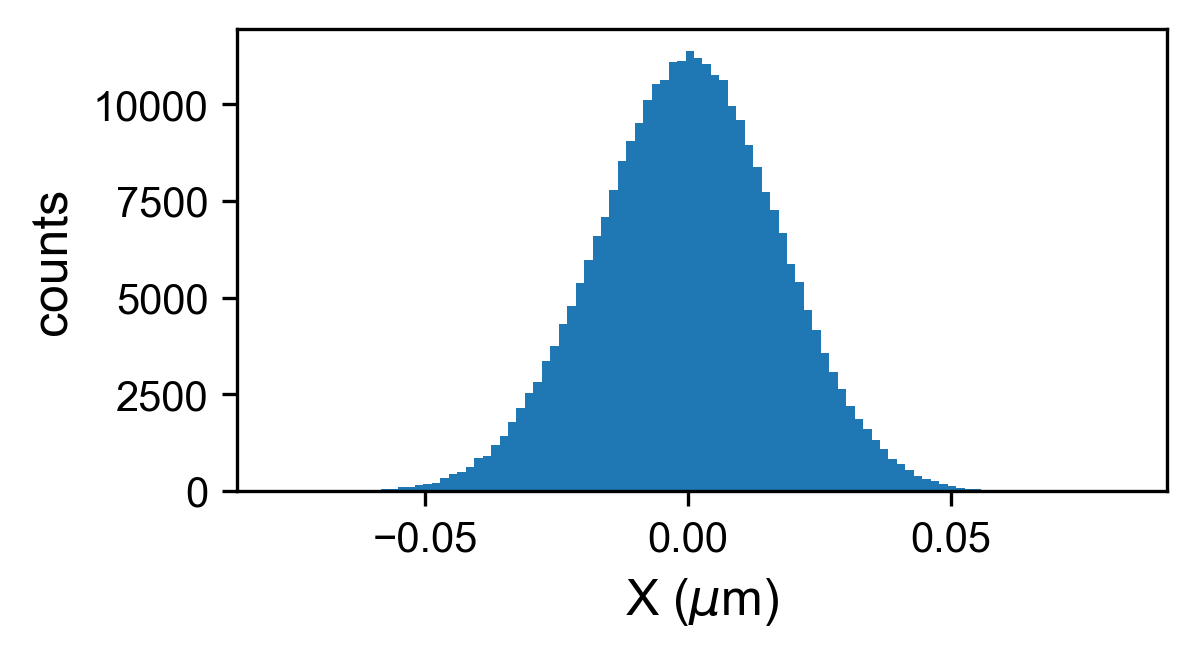

In [25]:
plt.figure(figsize=(4,2),dpi=300)
matplotlib.rcParams['font.sans-serif'] = "Arial"
h= plt.hist(xpos,100)
plt.xlabel("X ($\mu$m)",fontsize=12)
plt.ylabel("counts",fontsize=12)
plt.savefig(fname+'Xhisto.png',bbox_inches='tight')
np.savetxt(fname+"X histograms.txt", np.transpose(np.array([h[1][:100],h[0]])),delimiter='\t')
np.std(xpos)

0.017045781433465888

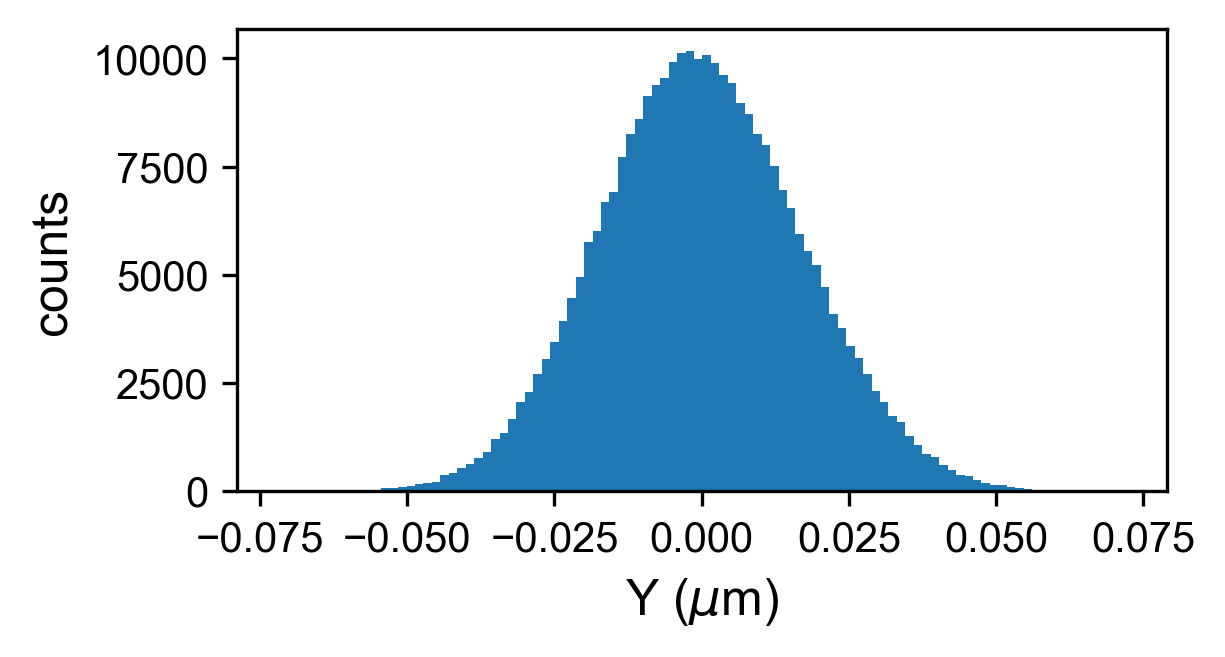

In [26]:
plt.figure(figsize=(4,2),dpi=300)
matplotlib.rcParams['font.sans-serif'] = "Arial"
h= plt.hist(ypos,100)
plt.xlabel("Y ($\mu$m)",fontsize=12)
plt.ylabel("counts",fontsize=12)
plt.savefig(fname+'Yhisto.png',bbox_inches='tight')
np.savetxt(fname+"Y histograms.txt", np.transpose(np.array([h[1][:100],h[0]])),delimiter='\t')
np.std(ypos)

In [27]:
np.shape(h[0])

(100,)

# Calculating the Autocorrelation functions in x and y
We use multipletau.autocorrelate and a user-defined ia_correlate to compute two versions of the autocorrelation function based on the time-lag spacing. multipletau.autocorrelate() uses a 2^n binning of lagtimes while ia_autocorrelate uses a 1.5^n binning of lagtimes. The latter is usefull if there are large long-time fluctuations of the signal. see (*Tassieri, M., Evans, R., Warren, R. L., Bailey, N. J. & Cooper, J. M. Microrheology with optical tweezers: data analysis. New Journal of Physics 14, 115032 (2012).*) for details. 

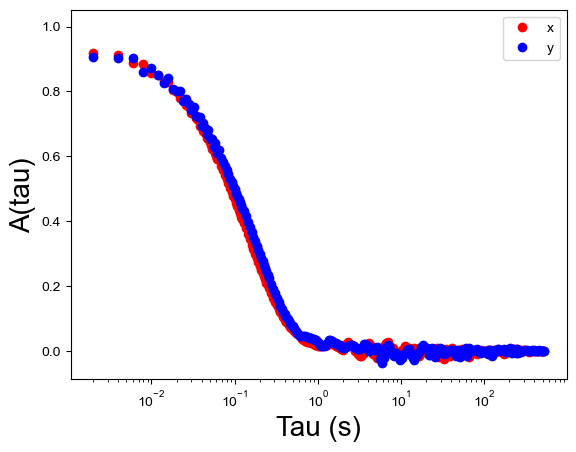

In [28]:
# set time interval
dt = t[1]
#compute correlations 
taux, Ax, Ay = compute_autocorrelation(xpos,ypos,dt) #for 2^2 time lags
itaux, iAx, iAy = ia_autocorr(xpos,ypos,25, dt) #for 1.5^n time lags, good if there are  long-time fluctuations in the data
kappax,kappay= get_stiffness(t,1000*xpos,1000*yposkappa,25) #Getting the trap stiffness through the equipartition theorem (see the manuscript)
#plot all
plt.semilogx(taux, Ax,'o',color='r',label='x')
plt.semilogx(taux, Ay,'o',color='b',label='y')
#plt.semilogx(itaux,iAx,'o',color='g',label='x')
#plt.semilogx(itaux,iAy,'o',color='y',label='y')
plt.xlabel('Tau (s)',fontsize=20)
plt.ylabel('A(tau)',fontsize=20)
plt.legend()
plt.savefig(fname+'Autocorrelation.png',bbox_inches='tight')
np.savetxt(fname+"Autocorr.txt", np.transpose(np.array([taux,Ax,Ay])))
np.savetxt(fname+"Autocorr_IA.txt", np.transpose(np.array([itaux,iAx,iAy])))

In [29]:
kappax,kappay

(1.3860664823628125e-05, 1.394156725468087e-05)

# Fitting the Autocorrelation functions in x and y
We use a three-exponential functions to fit the ACF. The number of exponentials is not fixed, you can increase if the fitting is not adequate. see (*Tassieri, M., Evans, R., Warren, R. L., Bailey, N. J. & Cooper, J. M. Microrheology with optical tweezers: data analysis. New Journal of Physics 14, 115032 (2012).*) for details. 

# Enter start and end lagtimes

[[Model]]
    Model(PMRfit)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 10
    # data points      = 241
    # variables        = 4
    chi-square         = 0.02917995
    reduced chi-square = 1.2312e-04
    Akaike info crit   = -2165.59593
    Bayesian info crit = -2151.65674
    R-squared          = 0.99839854
[[Variables]]
    G1:      0.95469828 +/- 0.00549272 (0.58%) (init = 1)
    l1:      6.03984211 +/- 0.06119001 (1.01%) (init = 1)
    gamma1:  0.83047872 +/- 0.00975775 (1.17%) (init = 1)
    G2:      0.00185685 +/- 9.1429e-04 (49.24%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(G1, gamma1) = -0.819
    C(G1, l1)     = 0.735
    C(l1, gamma1) = -0.533
    C(G1, G2)     = -0.265
    C(gamma1, G2) = 0.208
    C(l1, G2)     = 0.180


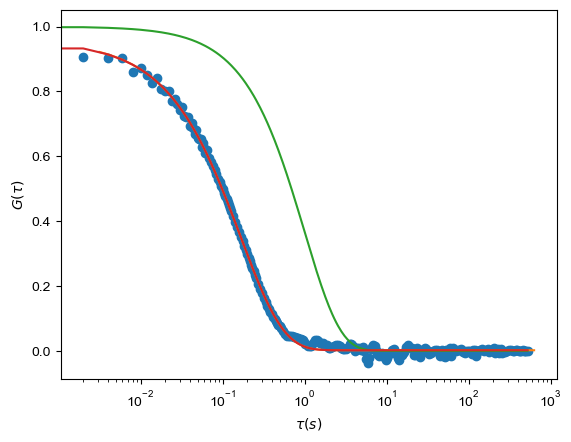

In [30]:
start_lagtime = -2.5 #in log10 (power)
end_lagtime=2.8 # in log 10, 1 means 10^1, 2 means 10^2

# define fitting function
def PMRfit(tau, G1,l1,gamma1,G2):
    return G1*np.exp(-(l1*tau)**gamma1)+G2

#initiate fiting object
modely = lmfit.Model(PMRfit)
params = modely.make_params(G1=1,l1=0.001,gamma1=1.,G2=1)
params['G1'].set(value=1.0, vary=True,max=5, min=0.0)
params['l1'].set(value=1., max=10000000.0, min=0.0)
params['gamma1'].set(value=1., vary=True,max=10, min=0.0)
params['G2'].set(value=.0, vary=True,max=5, min=0.0)

#fit
fitresy = modely.fit(Ay[:], tau=taux[:], params=params, 
                   method='least_squares')
print(fitresy.fit_report())

#plot stuff
plt.semilogx(taux[:],Ay[:],'o')

taunewy=np.logspace(start_lagtime,end_lagtime,100000)
Atimenewy=modely.eval(fitresy.params,tau=taunewy)
plt.semilogx(taunewy[:], Atimenewy[:])

plt.semilogx(taux[:], fitresy.init_fit)
plt.semilogx(taux[:], fitresy.best_fit)
plt.xlabel(r'$\tau (s)$')
plt.ylabel(r'$G(\tau)$')
plt.savefig('Autocorrelation_IA_y.png',bbox_inches='tight')

#save data as text files
#np.savetxt(fname+'_Autocorrelation_fit_y.txt', np.transpose([taux, Ay, fitresy.best_fit]))

[[Model]]
    Model(PMRfit)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 10
    # data points      = 241
    # variables        = 4
    chi-square         = 0.02917995
    reduced chi-square = 1.2312e-04
    Akaike info crit   = -2165.59593
    Bayesian info crit = -2151.65674
    R-squared          = 0.99839854
[[Variables]]
    G1:      0.95469828 +/- 0.00549272 (0.58%) (init = 1)
    l1:      6.03984211 +/- 0.06119001 (1.01%) (init = 1)
    gamma1:  0.83047872 +/- 0.00975775 (1.17%) (init = 1)
    G2:      0.00185685 +/- 9.1429e-04 (49.24%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(G1, gamma1) = -0.819
    C(G1, l1)     = 0.735
    C(l1, gamma1) = -0.533
    C(G1, G2)     = -0.265
    C(gamma1, G2) = 0.208
    C(l1, G2)     = 0.180


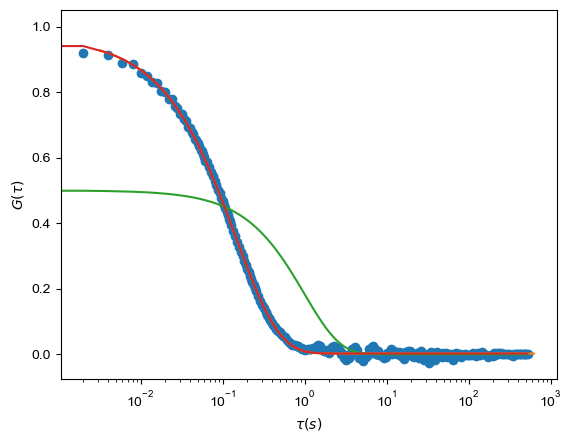

In [31]:

# initiate fitting object
modelx = lmfit.Model(PMRfit)
params = modely.make_params(G1=1,l1=0.001,gamma1=1.,G2=1,l2=0.01,gamma2=1.,G3=1,l3=0.1,gamma3=1.)
params['G1'].set(value=.5, vary=True,max=5, min=0.0)
params['l1'].set(value=1., max=10000000.0, min=0.0)
params['gamma1'].set(value=1., vary=True,max=10, min=0.0)
params['G2'].set(value=.0, vary=True,max=5, min=0.0)

#fit
fitresx = modelx.fit(Ax[:], tau=taux[:], params=params, 
                   method='least_squares')
print(fitresy.fit_report())

#plot all
plt.semilogx(taux[:],Ax[:],'o')
taunewx=np.logspace(start_lagtime,end_lagtime,100000)
Atimenewx=modely.eval(fitresx.params,tau=taunewx)
plt.semilogx(taunewx[:], Atimenewx[:])
plt.semilogx(taux[:], fitresx.init_fit)
plt.semilogx(taux[:], fitresx.best_fit)
plt.xlabel(r'$\tau (s)$')
plt.ylabel(r'$G(\tau)$')
plt.savefig('Autocorrelation_IA_x.png',bbox_inches='tight')
#save data as text file
#np.savetxt(fname+'_Autocorrelation_fit_x.txt', np.transpose([taux, Ax, fitresx.best_fit]))


In [33]:
#plt.semilogx(taux,Ay,'o')
fsmooth = interp1d(taux, Ay, kind='cubic')
trawy=np.logspace(start_lagtime,end_lagtime,1000*len(taux))
Arawy= fsmooth(trawy)
plt.semilogx(trawy,Arawy,'o')
#plt.semilogx(taux,Ax,'o')
fsmooth = interp1d(taux, Ax, kind='cubic')
trawx=np.logspace(start_lagtime,end_lagtime,1000*len(taux))
Arawx= fsmooth(trawy)
plt.semilogx(trawy,Arawx,'o')

ValueError: A value (524.2953607269075) in x_new is above the interpolation range's maximum value (524.288).

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline
s = InterpolatedUnivariateSpline(taunewx[1:], Atimenewx[1:], k=2)
s1 = InterpolatedUnivariateSpline(taunewy[1:], Atimenewy[1:], k=2)
itrawy1=np.logspace(-5,end_lagtime,1000*len(taux))
plt.semilogx(itrawy1,s(itrawy1))
plt.semilogx(taux[1:],Ax[1:])
g0x=s(0)
g0y=s1(0)

plt.semilogx(itrawy1,s1(itrawy1))
plt.semilogx(taux[1:100000],Ay[1:100000])
plt.ylim([0,1])

In [ ]:
g0x,g0y

# Calculating the Rheological moduli
We call the user-defined function PMR to calculate G' and G''. PMR caclulates the rheological properties by first performing a discrete Fourier transform of the Autocorrelation function and then uses the formula $$ G^*(\omega) =\frac{\kappa}{6\pi a}  (\frac{i\omega A(\omega)}{1-i\omega A(\omega)})$$

In [ ]:
# for fitted ACF

omegas1y,Afreq1y= PMR(trawy,Arawy,g0y,0.0)
Pomega1=1-1j*omegas1y*Afreq1y
G =  (kappay/(6*np.pi*0.5e-6))*(1./Pomega1-1) 
plt.figure(figsize=(6,4),dpi=300)
plt.loglog(omegas1y,abs(G.real),'o-',label='Storage Modulus G\'',alpha=0.5)
plt.loglog(omegas1y,G.imag,'o-',label='Loss Modulus G\'\'',alpha=0.5)
plt.xlabel('$\omega$ (1/s)',fontsize=18)
plt.ylabel('G\', G\'\' (Pa)',fontsize=18)
plt.legend(frameon=False)
grid()
plt.xlim(.1,300)
plt.ylim(.001,50)
#plt.xlim(1/10**end_lagtime,1/10**start_lagtime)
plt.savefig('Moduli_Passive_all_y'+fname+'.png',bbox_inches='tight')


# Save data
Save data as columns with the following order: omega, G' from fitted, G'' from fitted , omega, G' raw, G'' raw, viscosity from fit

In [ ]:
plt.figure(figsize=(6,4),dpi=300)
plt.loglog(omegas1y,G.imag/omegas1y,'o',label='Viscosity',alpha=0.5)
plt.xlabel('$\omega$ (1/s)',fontsize=18)
plt.ylabel('viscosity (Pa.s)',fontsize=18)
plt.legend(frameon=False)
grid()
plt.xlim(.1,300)
plt.savefig('Viscosity_y'+fname+'.png',bbox_inches='tight')
np.savetxt(fname+'moduli-y.txt',np.transpose([omegas1y, abs(G.real),G.imag, G.imag/omegas1y]),delimiter='	',fmt='%1.9f')


In [ ]:
# For fitted ACF

omegas1x,Afreq1x= PMR(trawx,Arawx,g0x,0.0)

Pomega1=1-1j*omegas1x*Afreq1x
G =  (kappax/(6*np.pi*0.5e-6))*(1./Pomega1-1) 


plt.figure(figsize=(6,4),dpi=300)

plt.loglog(omegas1x,abs(G.real),'o-',label='Storage Modulus G\'',alpha=0.5)
plt.loglog(omegas1x,(G.imag),'o-',label='Loss Modulus G\'\'',alpha=0.5)

plt.xlabel('$\omega$ (1/s)',fontsize=18)
plt.ylabel('G\', G\'\' (Pa)',fontsize=18)
plt.legend(frameon=False)
grid()
plt.xlim(1/10**end_lagtime,1/10**start_lagtime)
plt.xlim(.1,300)
plt.ylim(.001,50)
#plt.ylim(.001,1000)
plt.savefig('Moduli_Passive_all_x'+fname+'.png',bbox_inches='tight')


In [ ]:
plt.figure(figsize=(6,4),dpi=300)
plt.loglog(omegas1x,G.imag/omegas1x,'o',label='Viscosity',alpha=0.5)
plt.xlabel('$\omega$ (1/s)',fontsize=18)
plt.ylabel('Viscosity (Pa.s)',fontsize=18)
plt.legend(frameon=False)
plt.xlim(.1,300)
grid()
plt.savefig('Viscosity_x'+fname+'.png',bbox_inches='tight')
np.savetxt(fname+'moduli-x.txt',np.transpose([omegas1x, abs(G.real),G.imag, G.imag/omegas1x]),delimiter='	',fmt='%1.9f')


In [ ]:
kappax,kappay

In [ ]:
kappax/kappay